### Azure AI評価



1. ライブラリのインポート

In [1]:
import os
import re

from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv
import pandas as pd
from openai import AzureOpenAI
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.models import VectorizedQuery
import json
from azure.cosmos import PartitionKey
from azure.cosmos.cosmos_client import CosmosClient
from datetime import datetime

2. 環境変数の読み込み

In [2]:
# Load environment variables
load_dotenv(override=True)

AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_MODEL = os.getenv("AZURE_OPENAI_CHAT_MODEL")
AZURE_OPENAI_EMBED_MODEL = os.getenv("AZURE_OPENAI_EMBED_MODEL")
AZURE_OPENAI_CHAT_MAX_TOKENS = int(os.getenv("AZURE_OPENAI_CHAT_MAX_TOKENS", "1000"))

# Azure OpenAI Service の情報を環境変数から取得する
client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION")
)


# Azure AI Search の情報を環境変数から取得する
AI_SEARCH_ENDPOINT = os.getenv("AI_SEARCH_ENDPOINT")
AI_SEARCH_KEY = os.getenv("AI_SEARCH_KEY")
AI_SEARCH_API_VERSION = os.getenv("AI_SEARCH_API_VERSION", "2023-10-01-Preview")
AI_SEARCH_INDEX_NAME = os.getenv("AI_SEARCH_INDEX_NAME")
AI_SEACH_SEMANTIC = os.getenv("AI_SEACH_SEMANTIC")

SUBSCRIPTION_ID = os.getenv("SUBSCRIPTION_ID")
RESOURCE_GROUP_NAME = os.getenv("RESOURCE_GROUP_NAME")
PROJECT_NAME = os.getenv("PROJECT_NAME")

COSMOS_CONNECTION_STRING = os.getenv("COSMOS_CONNECTION_STRING")
COSMOS_DB_NAME = os.getenv("COSMOS_DB_NAME")
COSMOS_CONTAINER_NAME_CHAT = os.getenv("COSMOS_CONTAINER_NAME_CHAT")

# 検索結果の上位何件を取得するか
TOP_K = 5

# 生成回答を追加したQnAペアを保存するリスト
augmented_qna_pairs = []  

3. 評価データの読み込み
    
・適宜、データパスを変更

・query, ground_truthのデータを保持していること

In [3]:
def load_qna_pairs(jsonl_file_path):
    qna_pairs = []
    with open(jsonl_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line.strip())
            query = data.get('query')
            ground_truth = data.get('ground_truth')
            if query and ground_truth:
                qna_pairs.append({'query': query, 'ground_truth': ground_truth})
    return qna_pairs

# 例として、'qna_pairs.jsonl'というファイルから読み込む
qna_pairs = load_qna_pairs('./eval/input/rag_input.jsonl')



4. 関数定義

In [4]:
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizedQuery

def generate_embeddings(text, text_limit=7000):
    # テキストの前処理
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[\n\r]+', ' ', text).strip()
    if len(text) > text_limit:
        text = text[:text_limit]
    response = client.embeddings.create(model=AZURE_OPENAI_EMBED_MODEL, input=text)
    embeddings = response.data[0].embedding
    return embeddings

def query_vector_index(index_name, query, search_type='Vector_only', top_k=TOP_K):
    vector = generate_embeddings(query)
    search_client = SearchClient(AI_SEARCH_ENDPOINT, index_name, AzureKeyCredential(AI_SEARCH_KEY))
    vector_query = VectorizedQuery(vector=vector, fields="contentVector")
    if search_type == "Vector_only":
        search_text = None
    else:
        search_text = query

    if search_type in ["Vector_only", "Hybrid"]:
        results = search_client.search(search_text=search_text, vector_queries=[vector_query], top=top_k)
    else:
        results = search_client.search(search_text=search_text, vector_queries=[vector_query], top=top_k,
                                       query_type='semantic', semantic_configuration_name=AI_SEACH_SEMANTIC)
    return results

def get_context_from_results(results):
    context = ""
    for result in results:
        filename = result.get('fileName', '')
        content = result.get('content', '')
        context += f"## filename: {filename}\n\n ## context {content}\n\n"
    return context

def generate_answer(question, context, system_prompt, temperature=0.0):
    # プロンプトの構築
    prompt = f"{system_prompt}\n\n# Sources(情報源):\n\n{context}\n\n# 質問:\n{question}\n\n# 回答を生成してください。"
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": question}
    ]
    response = client.chat.completions.create(
        model=AZURE_OPENAI_CHAT_MODEL,
        messages=messages,
        temperature=temperature,
        max_tokens=AZURE_OPENAI_CHAT_MAX_TOKENS
    )
    answer = response.choices[0].message.content.strip()
    return answer


5. RAGの実行

In [5]:
augmented_qna_pairs = []  # 生成回答を追加したQnAペアを保存するリスト

SystemPrompt = """あなたは、会社の従業員が社内のナレッジやドキュメントに対する質問をする際に支援する優秀なアシスタントです。
以下の制約を必ず守ってユーザの質問に回答してください。
ハルシネーションは起こさないでください。
魅力的で丁寧な回答をする必要があります。
最初から最後までじっくり読んで回答を作ってください。最高の仕事をしましょう

# 制約 
・以下のSources(情報源)に記載されたコンテキストのみを使用して回答してください。必ず情報源に記載されたコンテキストを基に回答を作ってください
・十分な情報がない場合は、わからないと回答してください。
・以下のSources(情報源)を使用しない回答は生成しないでください 。回答には役割(userやassistantなど)の情報を含めないでください。
・ユーザーの質問が不明瞭な場合は、明確化のためにユーザに質問してください。
・Sourcesには、名前の後にコロンと実際の情報が続きます。回答で使用する各事実について、常にSourcesの情報を含めてください。
  情報源を参照するには、各Content情報の前段にあるfilenameの情報を反映してください。角かっこを使用してください。
  Sources参照ルール：[filename] 　Sources出力例：[info1.txt]
・Sourcesを組み合わせないでください。各Sourcesを個別にリストしてください。例：[info1.txt],[info1.txt]
・日本語の質問の場合は、日本語で回答を作成してください。英語での質問の場合は、英語で回答を作成し回答してください。    
"""

for idx, qna in enumerate(qna_pairs):
    question = qna['query']
    reference_answer = qna['ground_truth']

    # 質問を検索エンジンに投げてコンテキストを取得
    results = query_vector_index(AI_SEARCH_INDEX_NAME, question)
    context = get_context_from_results(results)

    # コンテキストと質問を用いて回答を生成
    generated_answer = generate_answer(question, context, SystemPrompt)

    # 生成された回答をQnAペアに追加
    augmented_qna = qna.copy()
    augmented_qna['response'] = generated_answer
    augmented_qna['context'] = context
    augmented_qna_pairs.append(augmented_qna)

6. RAG結果の出力

In [6]:
    # 現在の日時を取得してフォーマット
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

    # 生成された回答とコンテキストを追加したQnAペアを新しいJSONLファイルとして保存
    output_file_path = f'./eval/output/eval_rag_{current_time}.jsonl'
    with open(output_file_path, 'w', encoding='utf-8') as f:
        for augmented_qna in augmented_qna_pairs:
            json_line = json.dumps(augmented_qna, ensure_ascii=False)
            f.write(json_line + '\n')

In [7]:
azure_ai_project = { 
    "subscription_id": SUBSCRIPTION_ID,
    "resource_group_name": RESOURCE_GROUP_NAME,
    "project_name": PROJECT_NAME
}

env_var = {
    "gpt-4o": {
        "endpoint": f"{AZURE_OPENAI_ENDPOINT}/deployments/{AZURE_OPENAI_CHAT_MODEL}/chat/completions?api-version=2024-06-01",
        "key": f"{AZURE_OPENAI_API_KEY}",
    },
}

### AI Eval

7. 評価の実行

In [8]:
from azure.ai.evaluation import RelevanceEvaluator, CoherenceEvaluator, GroundednessEvaluator, FluencyEvaluator, SimilarityEvaluator, QAEvaluator 

# Initialize Azure OpenAI Connection with your environment variables
model_config = {
    "azure_endpoint": AZURE_OPENAI_ENDPOINT,
    "api_key": AZURE_OPENAI_API_KEY,
    "azure_deployment": AZURE_OPENAI_CHAT_MODEL,
    "api_version": "2024-06-01",
    "type": "azure_openai",
}

results=[]

# jsonlファイルからquery, response, context, ground_truthを読み込み、評価を行う
for augmented_qna in augmented_qna_pairs:
    query = augmented_qna['query']
    response = augmented_qna['response']
    context = augmented_qna['context']
    ground_truth = augmented_qna['ground_truth']

    eval_fn = QAEvaluator(model_config)

    result = eval_fn(
        query=query,
        response=response,
        context=context,
        ground_truth=ground_truth
    )

    #result結果にquery, response, context, ground_truthを追記
    result['query'] = query
    result['response'] = response
    result['context'] = context
    result['ground_truth'] = ground_truth

    #results配列にresult結果を追記
    results.append(result)

    print(result)

# 現在の日時を取得してフォーマット
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# ファイル名に日時情報を追加して保存
output_file_path = f'./eval/output/eval_results_{current_time}.jsonl'
with open(output_file_path, 'w', encoding='utf-8') as f:
    for result in results:
        json_line = json.dumps(result, ensure_ascii=False)
        f.write(json_line + '\n')

{'f1_score': 0.0, 'gpt_similarity': 3.0, 'gpt_fluency': 5.0, 'gpt_coherence': 5.0, 'gpt_groundedness': 5.0, 'gpt_relevance': 5.0, 'query': 'Pythonとは何ですか？', 'response': 'Pythonは、プログラミング言語の一つであり、特に人工知能（AI）やディープラーニングの分野で広く使用されています。Pythonはそのシンプルで読みやすい文法と豊富なライブラリが特徴で、初心者からプロフェッショナルまで幅広いユーザーに支持されています。\n\n具体的には、Pythonは以下のような特徴を持っています：\n\n- **シンプルで読みやすい文法**：Pythonのコードは他の多くのプログラミング言語に比べて直感的で読みやすいです。\n- **豊富なライブラリ**：Pythonには、データ解析、機械学習、ウェブ開発など様々な分野で利用できるライブラリが豊富に揃っています。\n- **クロスプラットフォーム**：PythonはWindows、macOS、Linuxなど様々なプラットフォームで動作します。\n\n特にAIやディープラーニングの分野では、TensorFlowやPyTorchといったディープラーニングライブラリがPythonで提供されており、これらのライブラリを使って高度な機械学習モデルを構築することができます。\n\n[20230217_AIの進化と日本の戦略_松尾研.pdf]', 'context': '## filename: 20230217_AIの進化と日本の戦略_松尾研.pdf\n\n ## context ## Logical Inference\n\nInput: Did you see that Google just hired an eloquent whale for their TPU team? It showed them how to communicate between two different pods !\n\nModel Output: TPUs are a type of computer chip that Google uses for deep learning.

8. 評価結果の可視化

   f1_score  gpt_coherence  gpt_relevance  gpt_fluency  gpt_similarity  \
0  0.000000            5.0            5.0          5.0             3.0   
1  0.333333            1.0            1.0          5.0             1.0   
2  0.000000            5.0            5.0          5.0             5.0   
3  0.000000            1.0            1.0          5.0             1.0   
4  0.000000            5.0            5.0          5.0             4.0   

   gpt_groundedness  
0               5.0  
1               1.0  
2               5.0  
3               1.0  
4               5.0  


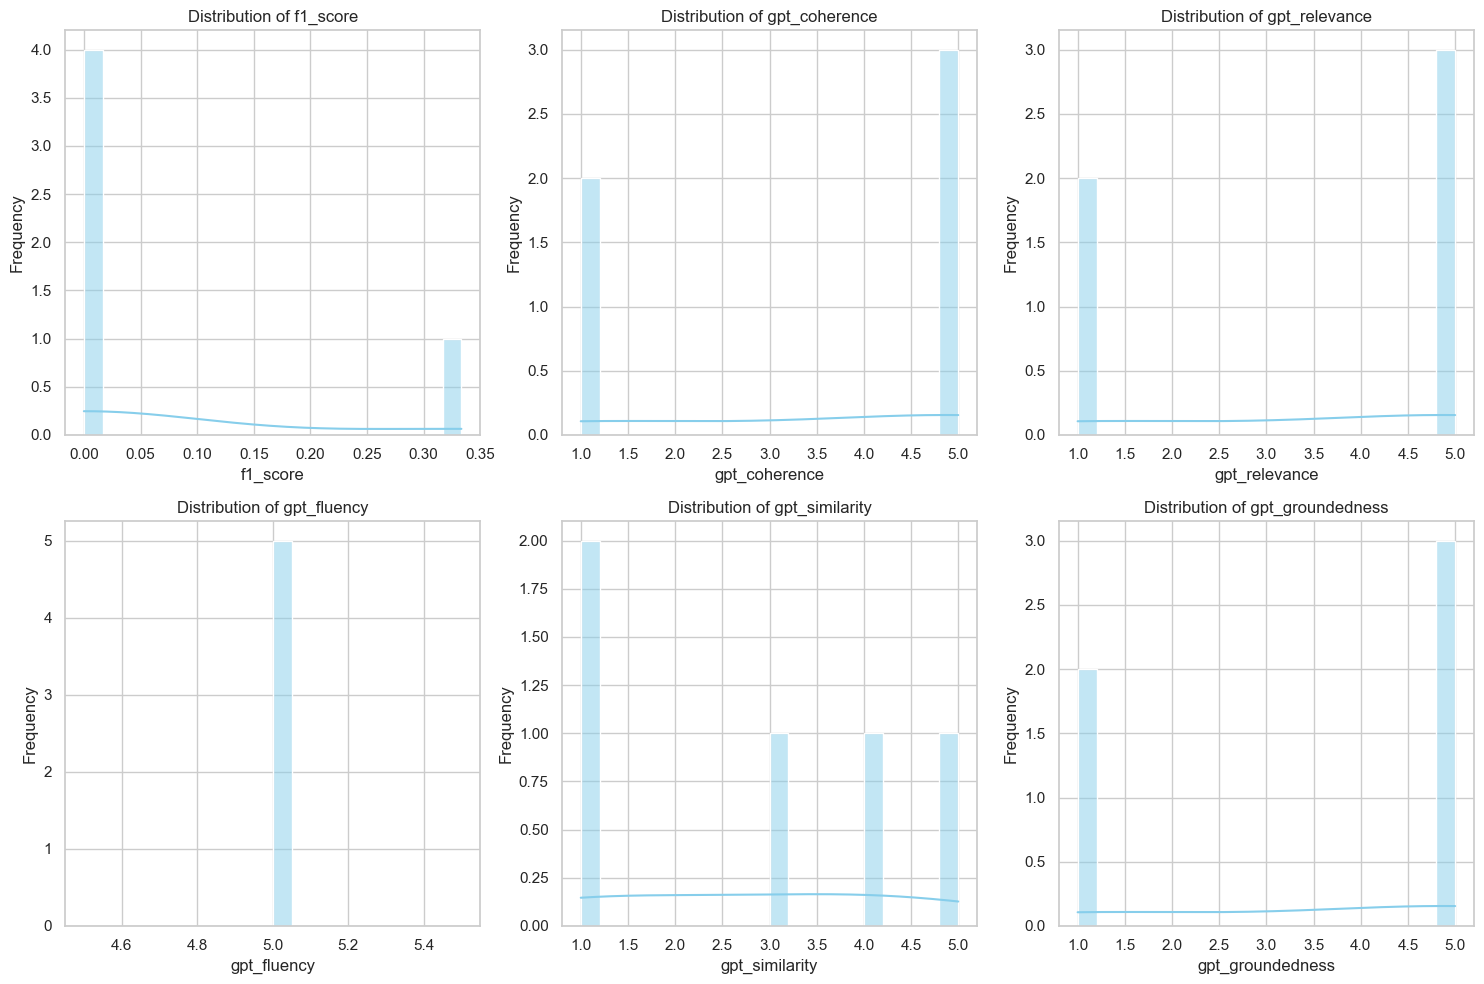

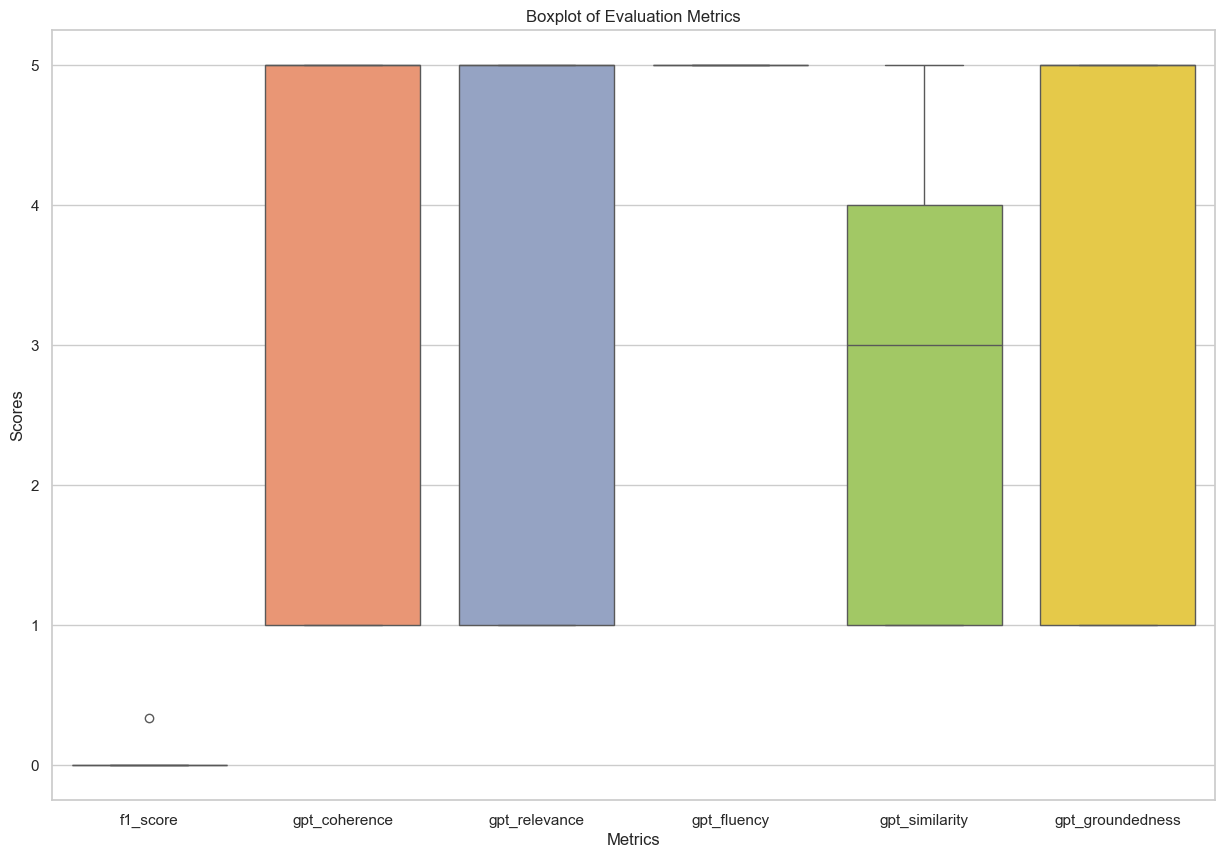

C:\Users\hnagasawa\AppData\Local\Temp\ipykernel_2128\3899238647.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=mean_scores.index, y=mean_scores.values, palette='viridis')


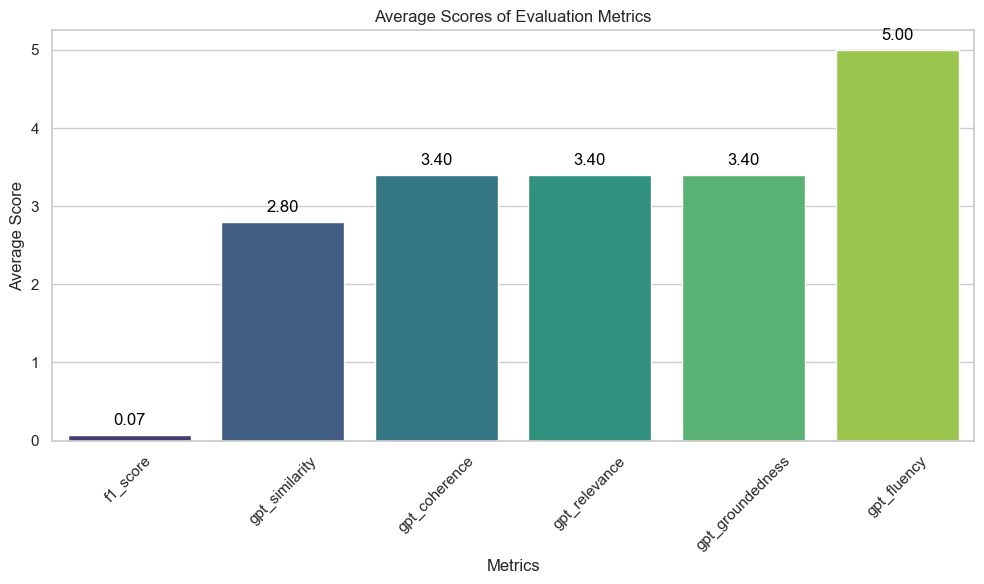

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# resultsをpandasのDataFrameに変換
df = pd.DataFrame(results)

# df内のf1_score,gpt_coherence,gpt_relevance,gpt_fluency,gpt_similarity,gpt_groundednessの項目のみを抽出
metrics = ['f1_score', 'gpt_coherence', 'gpt_relevance', 'gpt_fluency', 'gpt_similarity', 'gpt_groundedness']

# 指標データのみを抽出
metrics_df = df[metrics]

# データの確認
print(metrics_df.head())
# グラフのスタイル設定
sns.set(style="whitegrid")

# 1. 各評価指標のヒストグラム
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.histplot(metrics_df[metric], bins=20, kde=True, color='skyblue')
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 2. 各評価指標のボックスプロット
plt.figure(figsize=(15, 10))
sns.boxplot(data=metrics_df, palette='Set2')
plt.title('Boxplot of Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.show()

# 3. 評価指標ごとの平均値の棒グラフに数値ラベルを追加
mean_scores = metrics_df.mean().sort_values()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=mean_scores.index, y=mean_scores.values, palette='viridis')
plt.title('Average Scores of Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Average Score')
plt.xticks(rotation=45)

# 各バーの上に平均値の数値を表示
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

